In [1]:
from fastai.vision.all import *

In [4]:
import os
path = './archive/oxford-iiit-pet/images'

In [4]:
path = untar_data(URLs.PETS, force_download=False)

In [6]:
path.ls()

(#2) [Path('C:/Users/DANIEL PC/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/DANIEL PC/.fastai/data/oxford-iiit-pet/images')]

In [7]:
fname = (path/'images').ls()[0]

In [9]:
re.findall(r"(.+)_\d+.jpg$", fname.name)

['Abyssinian']

In [13]:
fname

Path('C:/Users/DANIEL PC/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg')

In [14]:
data = 'bull_dog_100.jpg'
re.findall(r"(.+)_\d+.jpg$", data)

['bull_dog']

In [12]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter=RandomSplitter(seed=42),
                get_y=using_attr(RegexLabeller(r"(.+)_\d+.(jpg|png)$"), 'name'),
                item_tfms=Resize(460),
                batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [ ]:
list(dls[0])

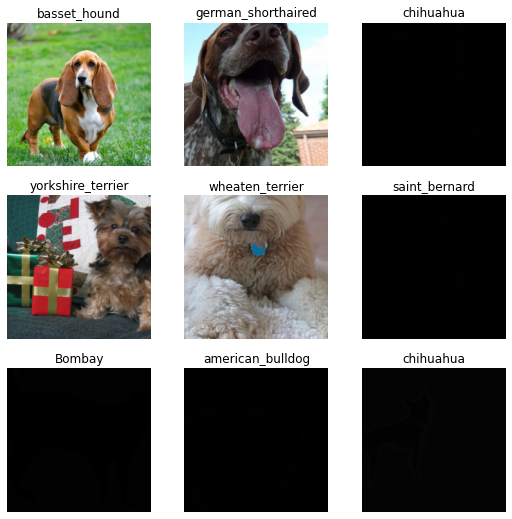

In [16]:
dls.show_batch()

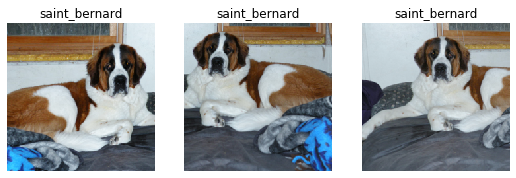

In [34]:
dls.show_batch(unique=True, nrows=1, ncols=3)

In [35]:
pets.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      archive\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      archive\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limit

In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
#learn.fine_tune(2)

In [17]:
x, y = dls.one_batch()

In [42]:
y.shape

torch.Size([64])

In [43]:
x.shape

torch.Size([64, 3, 224, 224])

In [41]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [ ]:
preds,_ learn.get_preds(dl=[x, y])
preds[0]

In [67]:
def softmaxx(x): return (torch.exp(x)) / (torch.exp(x).sum(dim=1, keepdim=True))

In [33]:
acts = torch.randn((6,2))*2
acts

tensor([[-0.3709, -2.5261],
        [ 0.3529,  0.3744],
        [-4.9579, -2.0337],
        [ 2.1827,  0.1072],
        [ 3.5613,  1.1312],
        [ 3.5063,  1.4756]])

In [34]:
acts.sigmoid()

tensor([[0.4083, 0.0741],
        [0.5873, 0.5925],
        [0.0070, 0.1157],
        [0.8987, 0.5268],
        [0.9724, 0.7561],
        [0.9709, 0.8139]])

In [35]:
diff = acts[:,0]-acts[:,1]
diff

tensor([ 2.1552, -0.0215, -2.9242,  2.0756,  2.4301,  2.0307])

In [36]:
diff.sigmoid()

tensor([0.8962, 0.4946, 0.0510, 0.8885, 0.9191, 0.8840])

In [37]:
sft = torch.stack([diff.sigmoid(), 1-diff.sigmoid()], dim=1)

In [26]:
sft[1, 0]+sft[1, 1]

tensor(1.)

In [38]:
sft

tensor([[0.8962, 0.1038],
        [0.4946, 0.5054],
        [0.0510, 0.9490],
        [0.8885, 0.1115],
        [0.9191, 0.0809],
        [0.8840, 0.1160]])

In [40]:
torch.softmax(acts, dim=1)

tensor([[0.8962, 0.1038],
        [0.4946, 0.5054],
        [0.0510, 0.9490],
        [0.8885, 0.1115],
        [0.9191, 0.0809],
        [0.8840, 0.1160]])

In [43]:
def mysoftmax(x): return torch.exp(x)/torch.exp(x).sum(dim=1,keepdim=True)

In [46]:
sm_acts = mysoftmax(acts)

In [45]:
targ = tensor([0,1,0,1,1,0])

In [47]:
idx = range(6)
sm_acts[idx,targ]

tensor([0.8962, 0.5054, 0.0510, 0.1115, 0.0809, 0.8840])

In [52]:
F.cross_entropy(acts, targ)

tensor(1.4334)

In [55]:
-torch.log(sm_acts[idx,targ]).mean()

tensor(1.4334)